In [268]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import os
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping

# confirm Keras sees the GPU
from keras import backend
print(len(backend.tensorflow_backend._get_available_gpus()))

1


In [269]:
# Download dataset from https://www.kaggle.com/c/facial-keypoints-detection/data
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'

In [270]:
SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

In [271]:
def load(test=False, cols=None):
    """
    if test is True, load data from FTEST. If False, load data from FTRAIN.
    cols takes a list of column names, and returns only columns in the list.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))

    # convert image data to numpy array
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    # if column names are specified, extract only those columns.
    if cols:
        df = df[list(cols) + ['Image']]

    print(df.count())  # print number of entries for each column
    df = df.dropna()  # drop rows which lack some data

    X = np.vstack(df['Image'].values) / 255.  # Convert color between 0 to 1
    X = X.astype(np.float32)
    
    # only FTRAIN has labels
    if not test:
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # convert data to -1 to 1
        X, y = shuffle(X, y, random_state=42)  # shuffle data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

# X, y = load()
# print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
#     X.shape, X.min(), X.max()))
# print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
#     y.shape, y.min(), y.max()))

In [272]:
def load2d(test=False, cols=None):
    X, y = load(test, cols)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='x', s=10)

In [273]:
class FlippedImageDataGenerator(ImageDataGenerator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def next(self):
        X_batch, y_batch = super(FlippedImageDataGenerator, self).next()
        batch_size = X_batch.shape[0]
        indices = np.random.choice(batch_size, batch_size/2, replace=False)
        X_batch[indices] = X_batch[indices, :, :, ::-1]

        if y_batch is not None:
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1

            for a, b in self.flip_indices:
                y_batch[indices, a], y_batch[indices, b] = (
                    y_batch[indices, b], y_batch[indices, a]
                )

        return X_batch, y_batch

In [274]:
# model1: deep neural network only
model = Sequential()
model.add(Dense(100, input_dim=9216))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(30))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(30))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(30))
model.add(BatchNormalization())

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)


In [275]:
X, y = load()
hist = model.fit(X, y, epochs=2000, validation_split=0.2)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

1712/1712 [==============================] - 0s 242us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 68/2000
1712/1712 [==============================] - 0s 226us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 69/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 70/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 71/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 72/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 73/2000
1712/1712 [==============================] - 0s 262us/step - loss: 0.0035 - val_loss: 0.0033
Epoch 74/2000
1712/1712 [==============================] - 0s 247us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 75/2000
1712/1712 [==============================] - 1s 293us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 76/2000
1712/1712 [==========================

1712/1712 [==============================] - 0s 272us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 144/2000
1712/1712 [==============================] - 0s 254us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 145/2000
1712/1712 [==============================] - 0s 243us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 146/2000
1712/1712 [==============================] - 0s 233us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 147/2000
1712/1712 [==============================] - 0s 227us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 148/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 149/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 150/2000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 151/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 152/2000
1712/1712 [=================

Epoch 219/2000
1712/1712 [==============================] - 0s 247us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 220/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 221/2000
1712/1712 [==============================] - 0s 225us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 222/2000
1712/1712 [==============================] - 0s 221us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 223/2000
1712/1712 [==============================] - 0s 233us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 224/2000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 225/2000
1712/1712 [==============================] - 0s 221us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 226/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 227/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 228/2000
1712/1712 [==

1712/1712 [==============================] - 0s 232us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 295/2000
1712/1712 [==============================] - 0s 227us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 296/2000
1712/1712 [==============================] - 0s 235us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 297/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 298/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 299/2000
1712/1712 [==============================] - 0s 237us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 300/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 301/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 302/2000
1712/1712 [==============================] - 0s 221us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 303/2000
1712/1712 [=================

Epoch 370/2000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 371/2000
1712/1712 [==============================] - 0s 222us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 372/2000
1712/1712 [==============================] - 0s 222us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 373/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 374/2000
1712/1712 [==============================] - 0s 229us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 375/2000
1712/1712 [==============================] - 0s 245us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 376/2000
1712/1712 [==============================] - 0s 272us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 377/2000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 378/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 379/2000
1712/1712 [==

Epoch 446/2000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 447/2000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 448/2000
1712/1712 [==============================] - ETA: 0s - loss: 0.002 - 0s 235us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 449/2000
1712/1712 [==============================] - 0s 238us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 450/2000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 451/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 452/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 453/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 454/2000
1712/1712 [==============================] - 0s 235us/step - loss: 0.0026 - val_loss: 0.0026
Epoc

1712/1712 [==============================] - 0s 237us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 522/2000
1712/1712 [==============================] - 0s 234us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 523/2000
1712/1712 [==============================] - 0s 237us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 524/2000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 525/2000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 526/2000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 527/2000
1712/1712 [==============================] - 0s 243us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 528/2000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 529/2000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 530/2000
1712/1712 [=================

Epoch 597/2000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 598/2000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 599/2000
1712/1712 [==============================] - ETA: 0s - loss: 0.002 - 0s 237us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 600/2000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 601/2000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 602/2000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 603/2000
1712/1712 [==============================] - 0s 244us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 604/2000
1712/1712 [==============================] - 0s 234us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 605/2000
1712/1712 [==============================] - 0s 231us/step - loss: 0.0024 - val_loss: 0.0024
Epoc

1712/1712 [==============================] - 0s 225us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 673/2000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 674/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 675/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 676/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 677/2000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 678/2000
1712/1712 [==============================] - 0s 229us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 679/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 680/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 681/2000
1712/1712 [=================

1712/1712 [==============================] - 0s 226us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 748/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 749/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 750/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 751/2000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0023 - val_loss: 0.0023
Epoch 752/2000
1712/1712 [==============================] - 0s 242us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 753/2000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 754/2000
1712/1712 [==============================] - 0s 233us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 755/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 756/2000
1712/1712 [=================

Epoch 823/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 824/2000
1712/1712 [==============================] - 0s 225us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 825/2000
1712/1712 [==============================] - 0s 226us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 826/2000
1712/1712 [==============================] - 0s 227us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 827/2000
1712/1712 [==============================] - 0s 227us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 828/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 829/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 830/2000
1712/1712 [==============================] - 0s 233us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 831/2000
1712/1712 [==============================] - 0s 225us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 832/2000
1712/1712 [==

Epoch 899/2000
1712/1712 [==============================] - 0s 226us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 900/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 901/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 902/2000
1712/1712 [==============================] - 0s 229us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 903/2000
1712/1712 [==============================] - 0s 222us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 904/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 905/2000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 906/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 907/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 908/2000
1712/1712 [==

1712/1712 [==============================] - 0s 217us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 975/2000
1712/1712 [==============================] - 0s 221us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 976/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 977/2000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 978/2000
1712/1712 [==============================] - 0s 237us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 979/2000
1712/1712 [==============================] - 0s 249us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 980/2000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 981/2000
1712/1712 [==============================] - 0s 240us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 982/2000
1712/1712 [==============================] - 0s 246us/step - loss: 0.0020 - val_loss: 0.0023
Epoch 983/2000
1712/1712 [=================

1712/1712 [==============================] - 0s 220us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1050/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1051/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1052/2000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1053/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1054/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1055/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1056/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1057/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1058/2000
1712/1712 [========

1712/1712 [==============================] - 0s 221us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1125/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1126/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1127/2000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1128/2000
1712/1712 [==============================] - 0s 226us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1129/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1130/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1131/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1132/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1133/2000
1712/1712 [========

1712/1712 [==============================] - 0s 218us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1200/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1201/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1202/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1203/2000
1712/1712 [==============================] - 0s 222us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1204/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 1205/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1206/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1207/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1208/2000
1712/1712 [========

1712/1712 [==============================] - 0s 232us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1275/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1276/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1277/2000
1712/1712 [==============================] - 0s 222us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1278/2000
1712/1712 [==============================] - 0s 244us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1279/2000
1712/1712 [==============================] - 0s 255us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1280/2000
1712/1712 [==============================] - 0s 262us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1281/2000
1712/1712 [==============================] - 0s 256us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1282/2000
1712/1712 [==============================] - 0s 251us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1283/2000
1712/1712 [========

Epoch 1349/2000
1712/1712 [==============================] - 0s 214us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1350/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1351/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1352/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1353/2000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1354/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1355/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 1356/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1357/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1358/2000
171

1712/1712 [==============================] - 0s 223us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1425/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1426/2000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1427/2000
1712/1712 [==============================] - 0s 227us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1428/2000
1712/1712 [==============================] - 0s 239us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1429/2000
1712/1712 [==============================] - 0s 241us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1430/2000
1712/1712 [==============================] - 0s 222us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1431/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1432/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1433/2000
1712/1712 [========

1712/1712 [==============================] - 0s 240us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1500/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1501/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1502/2000
1712/1712 [==============================] - 0s 222us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1503/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1504/2000
1712/1712 [==============================] - 0s 213us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1505/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1506/2000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1507/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1508/2000
1712/1712 [========

Epoch 1574/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1575/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1576/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1577/2000
1712/1712 [==============================] - 0s 227us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1578/2000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1579/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1580/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1581/2000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1582/2000
1712/1712 [==============================] - 0s 258us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1583/2000
171

Epoch 1649/2000
1712/1712 [==============================] - 0s 227us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1650/2000
1712/1712 [==============================] - 0s 240us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1651/2000
1712/1712 [==============================] - 0s 225us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1652/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1653/2000
1712/1712 [==============================] - 0s 260us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1654/2000
1712/1712 [==============================] - 0s 232us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1655/2000
1712/1712 [==============================] - 0s 221us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1656/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1657/2000
1712/1712 [==============================] - 0s 229us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1658/2000
171

1712/1712 [==============================] - 0s 216us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1725/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1726/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1727/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1728/2000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1729/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 1730/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1731/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1732/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1733/2000
1712/1712 [========

1712/1712 [==============================] - 0s 223us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1800/2000
1712/1712 [==============================] - 0s 224us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1801/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1802/2000
1712/1712 [==============================] - 0s 234us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1803/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1804/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1805/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1806/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1807/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1808/2000
1712/1712 [========

1712/1712 [==============================] - 0s 217us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1875/2000
1712/1712 [==============================] - 0s 230us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1876/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1877/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1878/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1879/2000
1712/1712 [==============================] - 0s 217us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1880/2000
1712/1712 [==============================] - 0s 222us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1881/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1882/2000
1712/1712 [==============================] - 0s 219us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1883/2000
1712/1712 [========

1712/1712 [==============================] - 0s 218us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1950/2000
1712/1712 [==============================] - 0s 220us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1951/2000
1712/1712 [==============================] - 0s 223us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1952/2000
1712/1712 [==============================] - 0s 218us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 1953/2000
1712/1712 [==============================] - 0s 228us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1954/2000
1712/1712 [==============================] - 0s 246us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1955/2000
1712/1712 [==============================] - 0s 245us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1956/2000
1712/1712 [==============================] - 0s 216us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1957/2000
1712/1712 [==============================] - 0s 233us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 1958/2000
1712/1712 [========

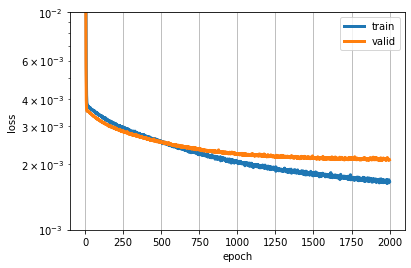

In [276]:
plt.plot(hist.history['loss'], linewidth=3, label='train')
plt.plot(hist.history['val_loss'], linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)
plt.yscale('log')
plt.show()

ImageId    1783
Image      1783
dtype: int64


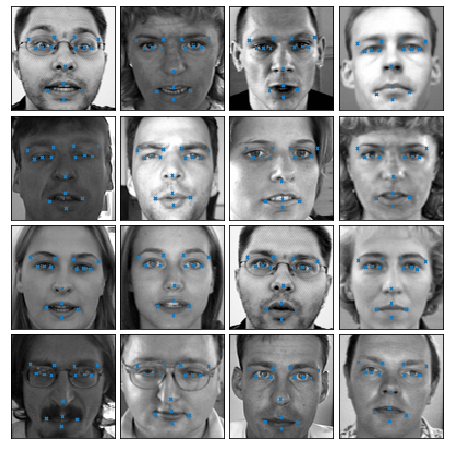

In [277]:
X_test, _ = load(test=True)
y_test = model.predict(X_test)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

plt.show()

In [278]:
json_string = model.to_json()
open('model1_architecture.json', 'w').write(json_string)
model.save_weights('model1_weights.h5')

In [279]:
X.shape

(2140, 9216)

In [280]:
y.shape

(2140, 30)

In [281]:
# Model 2: CNN

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,96,96), data_format='channels_first'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.1))

model2.add(Conv2D(64, (2, 2), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (2, 2), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

model2.add(Flatten())
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.1))

model2.add(Dense(30))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model2.compile(loss='mean_squared_error', optimizer=sgd)

In [282]:
X, y = load2d()
hist2 = model2.fit(X, y, epochs=5000, validation_split=0.2)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

1712/1712 [==============================] - 1s 421us/step - loss: 0.0054 - val_loss: 0.0044
Epoch 68/5000
1712/1712 [==============================] - 1s 418us/step - loss: 0.0053 - val_loss: 0.0044
Epoch 69/5000
1712/1712 [==============================] - 1s 405us/step - loss: 0.0052 - val_loss: 0.0043
Epoch 70/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0052 - val_loss: 0.0043
Epoch 71/5000
1712/1712 [==============================] - 1s 403us/step - loss: 0.0052 - val_loss: 0.0043
Epoch 72/5000
1712/1712 [==============================] - 1s 407us/step - loss: 0.0052 - val_loss: 0.0043
Epoch 73/5000
1712/1712 [==============================] - 1s 405us/step - loss: 0.0051 - val_loss: 0.0043
Epoch 74/5000
1712/1712 [==============================] - 1s 439us/step - loss: 0.0049 - val_loss: 0.0042
Epoch 75/5000
1712/1712 [==============================] - 1s 437us/step - loss: 0.0050 - val_loss: 0.0043
Epoch 76/5000
1712/1712 [==========================

1712/1712 [==============================] - 1s 423us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 144/5000
1712/1712 [==============================] - 1s 428us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 145/5000
1712/1712 [==============================] - 1s 426us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 146/5000
1712/1712 [==============================] - 1s 429us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 147/5000
1712/1712 [==============================] - 1s 430us/step - loss: 0.0044 - val_loss: 0.0043
Epoch 148/5000
1712/1712 [==============================] - 1s 433us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 149/5000
1712/1712 [==============================] - 1s 421us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 150/5000
1712/1712 [==============================] - 1s 432us/step - loss: 0.0043 - val_loss: 0.0042
Epoch 151/5000
1712/1712 [==============================] - 1s 427us/step - loss: 0.0043 - val_loss: 0.0043
Epoch 152/5000
1712/1712 [=================

1712/1712 [==============================] - 1s 409us/step - loss: 0.0042 - val_loss: 0.0041
Epoch 219/5000
1712/1712 [==============================] - 1s 415us/step - loss: 0.0042 - val_loss: 0.0041
Epoch 220/5000
1712/1712 [==============================] - 1s 411us/step - loss: 0.0042 - val_loss: 0.0041
Epoch 221/5000
1712/1712 [==============================] - 1s 408us/step - loss: 0.0042 - val_loss: 0.0042
Epoch 222/5000
1712/1712 [==============================] - 1s 418us/step - loss: 0.0042 - val_loss: 0.0042
Epoch 223/5000
1712/1712 [==============================] - 1s 414us/step - loss: 0.0042 - val_loss: 0.0042
Epoch 224/5000
1712/1712 [==============================] - 1s 420us/step - loss: 0.0042 - val_loss: 0.0042
Epoch 225/5000
1712/1712 [==============================] - 1s 426us/step - loss: 0.0042 - val_loss: 0.0041
Epoch 226/5000
1712/1712 [==============================] - 1s 418us/step - loss: 0.0042 - val_loss: 0.0042
Epoch 227/5000
1712/1712 [=================

Epoch 294/5000
1712/1712 [==============================] - 1s 425us/step - loss: 0.0041 - val_loss: 0.0041
Epoch 295/5000
1712/1712 [==============================] - 1s 451us/step - loss: 0.0041 - val_loss: 0.0041
Epoch 296/5000
1712/1712 [==============================] - 1s 450us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 297/5000
1712/1712 [==============================] - 1s 429us/step - loss: 0.0041 - val_loss: 0.0041
Epoch 298/5000
1712/1712 [==============================] - 1s 435us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 299/5000
1712/1712 [==============================] - 1s 423us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 300/5000
1712/1712 [==============================] - 1s 428us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 301/5000
1712/1712 [==============================] - 1s 441us/step - loss: 0.0041 - val_loss: 0.0041
Epoch 302/5000
1712/1712 [==============================] - 1s 438us/step - loss: 0.0041 - val_loss: 0.0041
Epoch 303/5000
1712/1712 [==

Epoch 369/5000
1712/1712 [==============================] - 1s 422us/step - loss: 0.0041 - val_loss: 0.0041
Epoch 370/5000
1712/1712 [==============================] - 1s 425us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 371/5000
1712/1712 [==============================] - 1s 416us/step - loss: 0.0041 - val_loss: 0.0041
Epoch 372/5000
1712/1712 [==============================] - 1s 431us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 373/5000
1712/1712 [==============================] - 1s 429us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 374/5000
1712/1712 [==============================] - 1s 419us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 375/5000
1712/1712 [==============================] - 1s 442us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 376/5000
1712/1712 [==============================] - 1s 425us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 377/5000
1712/1712 [==============================] - 1s 444us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 378/5000
1712/1712 [==

1712/1712 [==============================] - 1s 430us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 445/5000
1712/1712 [==============================] - 1s 435us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 446/5000
1712/1712 [==============================] - 1s 418us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 447/5000
1712/1712 [==============================] - 1s 423us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 448/5000
1712/1712 [==============================] - 1s 432us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 449/5000
1712/1712 [==============================] - 1s 438us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 450/5000
1712/1712 [==============================] - 1s 450us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 451/5000
1712/1712 [==============================] - 1s 432us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 452/5000
1712/1712 [==============================] - 1s 436us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 453/5000
1712/1712 [=================

Epoch 520/5000
1712/1712 [==============================] - 1s 428us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 521/5000
1712/1712 [==============================] - 1s 432us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 522/5000
1712/1712 [==============================] - 1s 433us/step - loss: 0.0039 - val_loss: 0.0040
Epoch 523/5000
1712/1712 [==============================] - 1s 433us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 524/5000
1712/1712 [==============================] - 1s 431us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 525/5000
1712/1712 [==============================] - 1s 431us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 526/5000
1712/1712 [==============================] - 1s 433us/step - loss: 0.0040 - val_loss: 0.0041
Epoch 527/5000
1712/1712 [==============================] - 1s 439us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 528/5000
1712/1712 [==============================] - 1s 429us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 529/5000
1712/1712 [==

1712/1712 [==============================] - 1s 438us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 596/5000
1712/1712 [==============================] - ETA: 0s - loss: 0.003 - 1s 425us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 597/5000
1712/1712 [==============================] - ETA: 0s - loss: 0.003 - 1s 432us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 598/5000
1712/1712 [==============================] - 1s 420us/step - loss: 0.0039 - val_loss: 0.0038
Epoch 599/5000
1712/1712 [==============================] - 1s 414us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 600/5000
1712/1712 [==============================] - 1s 410us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 601/5000
1712/1712 [==============================] - 1s 429us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 602/5000
1712/1712 [==============================] - 1s 451us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 603/5000
1712/1712 [==============================] - 1s 435us/step - loss: 0.0039 - val_loss: 0.

1712/1712 [==============================] - 1s 400us/step - loss: 0.0039 - val_loss: 0.0038
Epoch 671/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 672/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 673/5000
1712/1712 [==============================] - 1s 403us/step - loss: 0.0039 - val_loss: 0.0038
Epoch 674/5000
1712/1712 [==============================] - 1s 401us/step - loss: 0.0039 - val_loss: 0.0041
Epoch 675/5000
1712/1712 [==============================] - 1s 420us/step - loss: 0.0039 - val_loss: 0.0038
Epoch 676/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 677/5000
1712/1712 [==============================] - 1s 417us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 678/5000
1712/1712 [==============================] - 1s 450us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 679/5000
1712/1712 [=================

Epoch 746/5000
1712/1712 [==============================] - 1s 440us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 747/5000
1712/1712 [==============================] - 1s 417us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 748/5000
1712/1712 [==============================] - 1s 415us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 749/5000
1712/1712 [==============================] - 1s 443us/step - loss: 0.0039 - val_loss: 0.0038
Epoch 750/5000
1712/1712 [==============================] - 1s 442us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 751/5000
1712/1712 [==============================] - 1s 416us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 752/5000
1712/1712 [==============================] - 1s 427us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 753/5000
1712/1712 [==============================] - 1s 423us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 754/5000
1712/1712 [==============================] - 1s 416us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 755/5000
1712/1712 [==

Epoch 822/5000
1712/1712 [==============================] - 1s 422us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 823/5000
1712/1712 [==============================] - 1s 426us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 824/5000
1712/1712 [==============================] - 1s 431us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 825/5000
1712/1712 [==============================] - 1s 428us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 826/5000
1712/1712 [==============================] - 1s 429us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 827/5000
1712/1712 [==============================] - 1s 430us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 828/5000
1712/1712 [==============================] - 1s 431us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 829/5000
1712/1712 [==============================] - 1s 433us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 830/5000
1712/1712 [==============================] - 1s 429us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 831/5000
1712/1712 [==

Epoch 898/5000
1712/1712 [==============================] - 1s 401us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 899/5000
1712/1712 [==============================] - 1s 403us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 900/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 901/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 902/5000
1712/1712 [==============================] - 1s 406us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 903/5000
1712/1712 [==============================] - 1s 403us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 904/5000
1712/1712 [==============================] - 1s 403us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 905/5000
1712/1712 [==============================] - 1s 404us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 906/5000
1712/1712 [==============================] - 1s 403us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 907/5000
1712/1712 [==

1712/1712 [==============================] - 1s 402us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 974/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 975/5000
1712/1712 [==============================] - 1s 401us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 976/5000
1712/1712 [==============================] - 1s 403us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 977/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0037 - val_loss: 0.0036
Epoch 978/5000
1712/1712 [==============================] - 1s 403us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 979/5000
1712/1712 [==============================] - 1s 404us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 980/5000
1712/1712 [==============================] - 1s 404us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 981/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 982/5000
1712/1712 [=================

1712/1712 [==============================] - 1s 402us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 1049/5000
1712/1712 [==============================] - 1s 402us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 1050/5000
1712/1712 [==============================] - 1s 401us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 1051/5000
1712/1712 [==============================] - 1s 405us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 1052/5000
1712/1712 [==============================] - 1s 405us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 1053/5000
1712/1712 [==============================] - 1s 422us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 1054/5000
1712/1712 [==============================] - 1s 421us/step - loss: 0.0036 - val_loss: 0.0034
Epoch 1055/5000
1712/1712 [==============================] - 1s 411us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 1056/5000
1712/1712 [==============================] - 1s 417us/step - loss: 0.0036 - val_loss: 0.0035
Epoch 1057/5000
1712/1712 [========

KeyboardInterrupt: 

In [ ]:
plt.plot(hist2.history['loss'], linewidth=3, label='train')
plt.plot(hist2.history['val_loss'], linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)
plt.yscale('log')
plt.show()

In [ ]:
# compare output of two models

sample1 = load(test=True)[0][6:7]
sample2 = load2d(test=True)[0][6:7]
y_pred1 = model.predict(sample1)[0]
y_pred2 = model2.predict(sample2)[0]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1, y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample2, y_pred2, ax)
plt.show()

In [103]:
# model 3: For fit specialists

model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,96,96), data_format='channels_first'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.1))

model3.add(Conv2D(64, (2, 2), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(128, (2, 2), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.3))

model3.add(Flatten())
model3.add(Dense(1000, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(1000, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(30))

In [104]:
def fit_specialists(model, fname_pretrain=None):
    specialists = OrderedDict()
    start = 0.03
    stop = 0.001
    # nb_epoch = 10000
    nb_epoch = 10

    for setting in SPECIALIST_SETTINGS:

        cols = setting['columns']
        X, y = load2d(cols=cols)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        model_specialist = model_from_json(model.to_json())

        if fname_pretrain:
            model_specialist.load_weights(fname_pretrain)

        model_specialist.layers.pop()
        model_specialist.outputs = [model_specialist.layers[-1].output]
        model_specialist.layers[-1].outbound_nodes = []
        model_specialist.add(Dense(len(cols)))

        sgd = SGD(lr=start, momentum=0.9, nesterov=True)
        model_specialist.compile(loss='mean_squared_error', optimizer=sgd)

        # from keras.utils.visualize_util import plot
        # plot(model_specialist, to_file="model8_{}.png".format(cols[0]), show_shapes=True)

        flipgen = FlippedImageDataGenerator()
        flipgen.flip_indices = setting['flip_indices']

        early_stop = EarlyStopping(patience=100)
        learning_rates = np.linspace(start, stop, nb_epoch)
        change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

        print("Training model for columns {} for {} epochs".format(cols, nb_epoch))

        hist = model_specialist.fit_generator(flipgen.flow(X_train, y_train),
                                     steps_per_epoch=X_train.shape[0],
                                     epochs=nb_epoch,
                                     validation_data=(X_val, y_val),
                                     callbacks=[change_lr, early_stop])

        specialists[cols] = model_specialist

In [105]:
fit_specialists(model3)

left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 10 epochs
Epoch 1/10
5626/5626 [==============================] - 67s 12ms/step - loss: nan - val_loss: nan
Epoch 2/10
5626/5626 [==============================] - 65s 12ms/step - loss: nan - val_loss: nan
Epoch 3/10
5626/5626 [==============================] - 64s 11ms/step - loss: nan - val_loss: nan
Epoch 4/10
5626/5626 [==============================] - 65s 12ms/step - loss: nan - val_loss: nan
Epoch 5/10
3326/5626 [================>.............] - ETA: 26s - loss: nan

KeyboardInterrupt: 